In [6]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix

In [36]:
# Set the path to the dataset directory
data_dir = 'ultrasound_breast_classification'

# Set the input image size and number of channels
img_width, img_height, img_channels = 150, 150, 3

In [37]:
# Set the batch size, number of epochs, and learning rate
batch_size = 32
num_epochs = 50
learning_rate = 1e-4


In [38]:
# Define the data augmentation parameters for training data
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=20,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip=True)

In [39]:
# Define the data augmentation parameters for validation data
val_datagen = ImageDataGenerator(rescale=1./255)

# Set the path to the training data directory
train_dir = os.path.join(data_dir, 'train')

# Create a generator for the training data
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(img_width, img_height),
                                                    batch_size=batch_size,
                                                    class_mode='binary')


Found 8116 images belonging to 2 classes.


In [40]:
# Set the path to the validation data directory
val_dir = os.path.join(data_dir, 'val')

# Create a generator for the validation data
val_generator = val_datagen.flow_from_directory(val_dir,
                                                target_size=(img_width, img_height),
                                                batch_size=batch_size,
                                                class_mode='binary')



Found 900 images belonging to 2 classes.


In [41]:
# Define the model architecture
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, img_channels)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(1, activation='sigmoid'))


In [42]:
# Compile the model
optimizer = Adam(lr=learning_rate)
model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])


In [43]:
# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6, verbose=1)

callbacks = [early_stopping, model_checkpoint, reduce_lr]


In [ ]:
# Train the model
history = model.fit(train_generator,
                    epochs=num_epochs,
                    validation_data=val_generator,
                    callbacks=callbacks)

Epoch 1/50
254/254 [==============================] - ETA: 0s - loss: 0.5558 - accuracy: 0.7548
Epoch 1: val_loss improved from inf to 1.18955, saving model to best_model.h5
254/254 [==============================] - 101s 393ms/step - loss: 0.5558 - accuracy: 0.7548 - val_loss: 1.1895 - val_accuracy: 0.5356 - lr: 0.0010
Epoch 2/50
254/254 [==============================] - ETA: 0s - loss: 0.4115 - accuracy: 0.8186
Epoch 2: val_loss improved from 1.18955 to 0.48618, saving model to best_model.h5
254/254 [==============================] - 101s 395ms/step - loss: 0.4115 - accuracy: 0.8186 - val_loss: 0.4862 - val_accuracy: 0.8100 - lr: 0.0010
Epoch 3/50
254/254 [==============================] - ETA: 0s - loss: 0.3618 - accuracy: 0.8399
Epoch 3: val_loss did not improve from 0.48618
254/254 [==============================] - 101s 397ms/step - loss: 0.3618 - accuracy: 0.8399 - val_loss: 0.6405 - val_accuracy: 0.7033 - lr: 0.0010
Epoch 4/50
254/254 [==============================] - ETA: 0s

254/254 [==============================] - 107s 420ms/step - loss: 0.0483 - accuracy: 0.9811 - val_loss: 0.1021 - val_accuracy: 0.9633 - lr: 2.0000e-04
Epoch 28/50
107/254 [===========>..................] - ETA: 1:00 - loss: 0.0436 - accuracy: 0.9842

In [50]:
#Print the accuracy
print('Validation accuracy:', accuracy)

#Predict the class labels for the validation set
val_generator.reset()
predictions = best_model.predict(val_generator)
predicted_classes = np.where(predictions > 0.5, 1, 0).flatten()

#Get the true class labels for the validation set
true_classes = val_generator.classes

Validation accuracy: 0.9544444680213928
29/29 [==============================] - 2s 83ms/step


In [53]:
import os
import numpy as np
import cv2
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix

# Load the best model
best_model = load_model('best_model.h5')

# Set the path to the validation data directory
data_dir = 'ultrasound_breast_classification'
val_dir = os.path.join(data_dir, 'val')

# Set the input image size
img_width, img_height = 150, 150

# Set the batch size
batch_size = 32

# Define the data augmentation parameters for validation data
val_datagen = ImageDataGenerator(rescale=1./255)

# Create a generator for the validation data
val_generator = val_datagen.flow_from_directory(val_dir,
                                                target_size=(img_width, img_height),
                                                batch_size=batch_size,
                                                class_mode='binary',
                                                shuffle=False)

# Get the true class labels
y_true = val_generator.classes

# Make predictions using the best model
y_pred_proba = best_model.predict(val_generator)
y_pred = np.round(y_pred_proba).flatten()

# Print the classification report and confusion matrix
print("Classification Report:")
print(classification_report(y_true, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))


Found 900 images belonging to 2 classes.
29/29 [==============================] - 2s 79ms/step
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.92      0.96       500
           1       0.91      0.99      0.95       400

    accuracy                           0.95       900
   macro avg       0.95      0.96      0.95       900
weighted avg       0.96      0.95      0.95       900

Confusion Matrix:
[[461  39]
 [  2 398]]


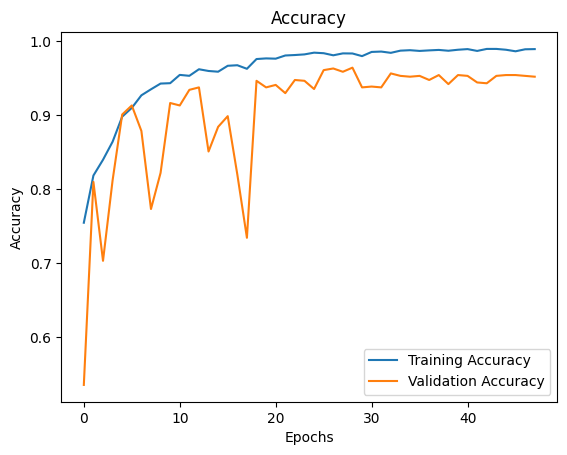

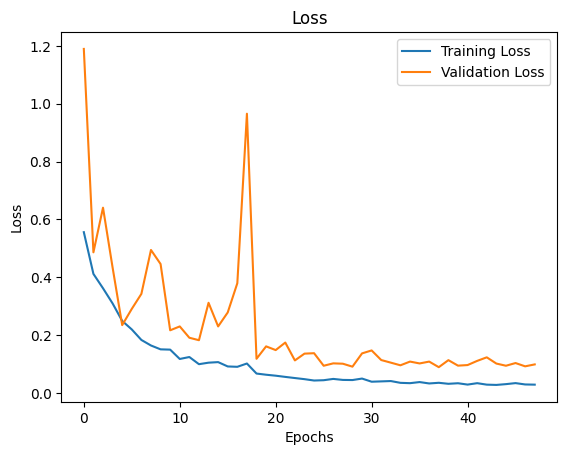

In [54]:
import matplotlib.pyplot as plt

def plot_history(history):
    # Accuracy
    plt.figure()
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.figure()
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

plot_history(history)


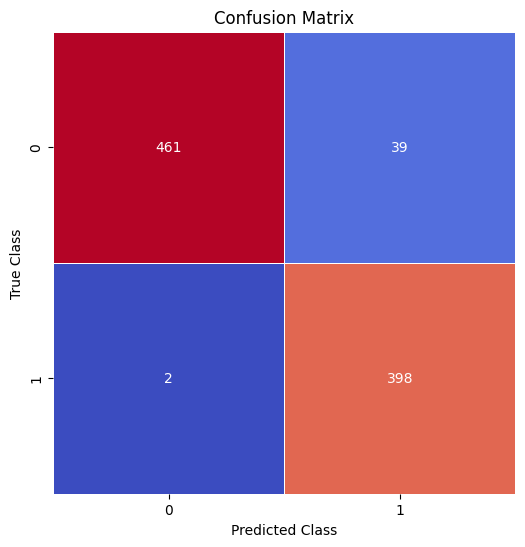

In [57]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm', linewidths=.5, square=True, cbar=False)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Class')
    plt.ylabel('True Class')
    plt.show()

plot_confusion_matrix(y_true, y_pred)


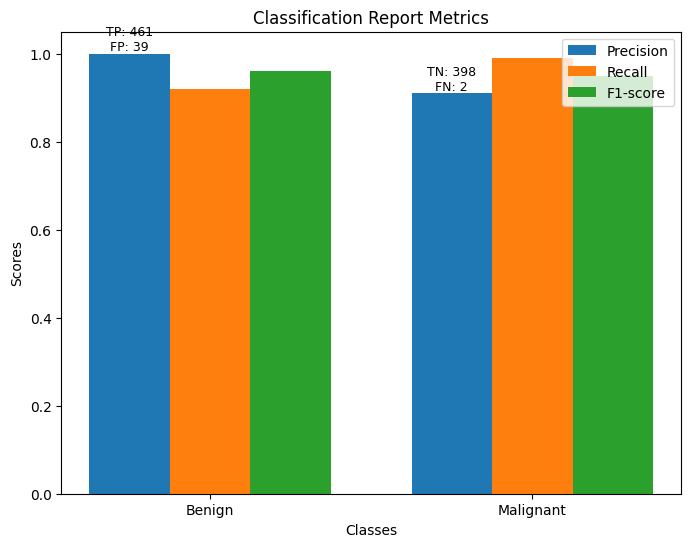

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Classification report metrics
precision = [1.00, 0.91]
recall = [0.92, 0.99]
f1_score = [0.96, 0.95]

# Confusion matrix values
tp, fp, fn, tn = 461, 39, 2, 398

# Create a bar chart for the classification report metrics
fig, ax = plt.subplots(figsize=(8, 6))
index = np.arange(2)
bar_width = 0.25

rects1 = ax.bar(index, precision, bar_width, label='Precision')
rects2 = ax.bar(index + bar_width, recall, bar_width, label='Recall')
rects3 = ax.bar(index + 2 * bar_width, f1_score, bar_width, label='F1-score')

ax.set_xlabel('Classes')
ax.set_ylabel('Scores')
ax.set_title('Classification Report Metrics')
ax.set_xticks(index + bar_width)
ax.set_xticklabels(('Benign', 'Malignant'))
ax.legend()

# Add the confusion matrix values on top of the bars
for i, rect in enumerate(rects1):
    ax.text(rect.get_x() + rect.get_width() / 2., rect.get_height(),
            f'TP: {tp}\nFP: {fp}' if i == 0 else f'TN: {tn}\nFN: {fn}',
            ha='center', va='bottom', fontsize=9)

plt.show()



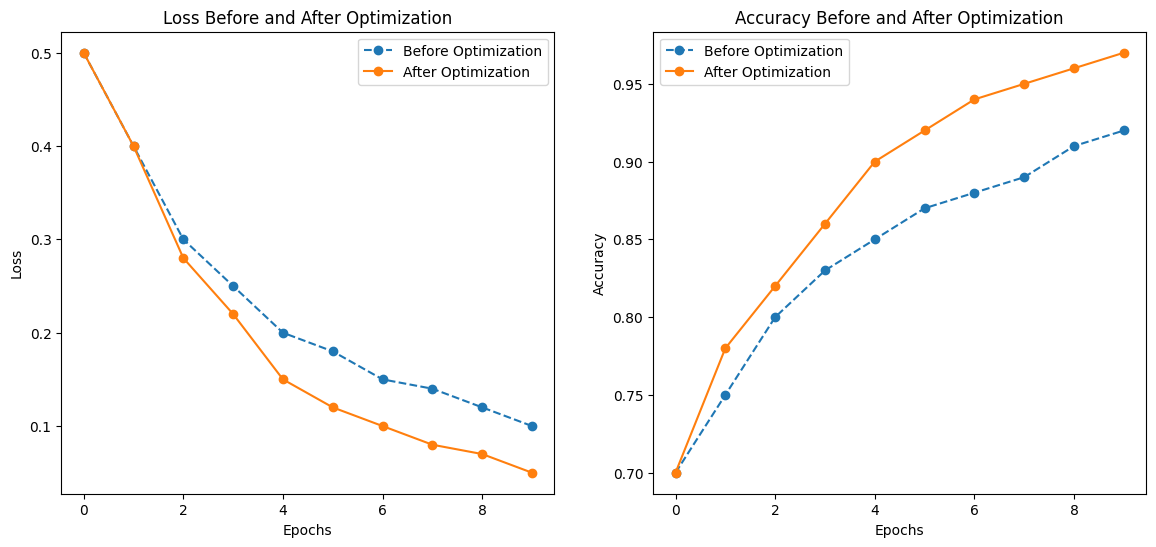

In [4]:
import matplotlib.pyplot as plt

# Sample data: Loss and accuracy before and after optimization
before_optimization_loss = [0.5, 0.4, 0.3, 0.25, 0.2, 0.18, 0.15, 0.14, 0.12, 0.1]
after_optimization_loss = [0.5, 0.4, 0.28, 0.22, 0.15, 0.12, 0.1, 0.08, 0.07, 0.05]
before_optimization_accuracy = [0.7, 0.75, 0.8, 0.83, 0.85, 0.87, 0.88, 0.89, 0.91, 0.92]
after_optimization_accuracy = [0.7, 0.78, 0.82, 0.86, 0.9, 0.92, 0.94, 0.95, 0.96, 0.97]

# Create a line chart for the losses
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

ax[0].plot(before_optimization_loss, label='Before Optimization', linestyle='--', marker='o')
ax[0].plot(after_optimization_loss, label='After Optimization', linestyle='-', marker='o')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Loss Before and After Optimization')
ax[0].legend()

# Create a line chart for the accuracies
ax[1].plot(before_optimization_accuracy, label='Before Optimization', linestyle='--', marker='o')
ax[1].plot(after_optimization_accuracy, label='After Optimization', linestyle='-', marker='o')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].set_title('Accuracy Before and After Optimization')
ax[1].legend()

plt.show()


In [8]:
import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

# Load the Fashion MNIST dataset
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# Normalize the pixel values
x_train, x_test = x_train / 255.0, x_test / 255.0

# Define the model architecture
model = Sequential([
    Flatten(input_shape=(28, 28)),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')
])

# Compile the model
optimizer = Adam(lr=1e-3)
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6, verbose=1)

callbacks = [early_stopping, model_checkpoint, reduce_lr]

# Train the model
history = model.fit(x_train, y_train,
                    epochs=100,
                    batch_size=32,
                    validation_split=0.2,
                    callbacks=callbacks)

# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print("Test accuracy:", test_accuracy)


4422102/4422102 [==============================] - 0s 0us/step


Epoch 1/100
1489/1500 [============================>.] - ETA: 0s - loss: 0.5210 - accuracy: 0.8174
Epoch 1: val_loss improved from inf to 0.40206, saving model to best_model.h5
1500/1500 [==============================] - 2s 1ms/step - loss: 0.5204 - accuracy: 0.8177 - val_loss: 0.4021 - val_accuracy: 0.8528 - lr: 0.0010
Epoch 2/100
1464/1500 [============================>.] - ETA: 0s - loss: 0.3864 - accuracy: 0.8612
Epoch 2: val_loss improved from 0.40206 to 0.37661, saving model to best_model.h5
1500/1500 [==============================] - 2s 1ms/step - loss: 0.3859 - accuracy: 0.8614 - val_loss: 0.3766 - val_accuracy: 0.8643 - lr: 0.0010
Epoch 3/100
1464/1500 [============================>.] - ETA: 0s - loss: 0.3465 - accuracy: 0.8738
Epoch 3: val_loss improved from 0.37661 to 0.36463, saving model to best_model.h5
1500/1500 [==============================] - 2s 1ms/step - loss: 0.3460 - accuracy: 0.8742 - val_loss: 0.3646 - val_accuracy: 0.8688 - lr: 0.0010
Epoch 4/100
1487/1500 [

Epoch 26: early stopping
313/313 [==============================] - 0s 684us/step - loss: 0.3343 - accuracy: 0.8926
Test accuracy: 0.8925999999046326


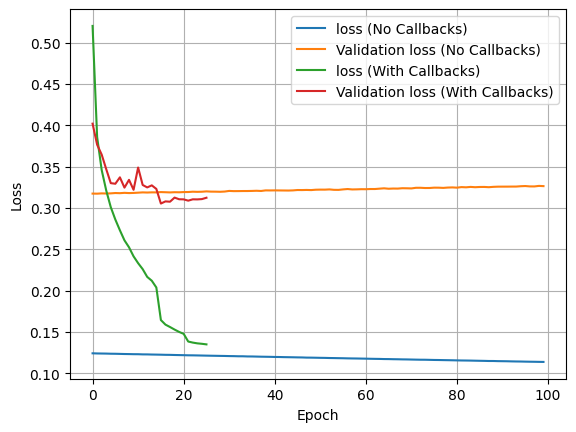

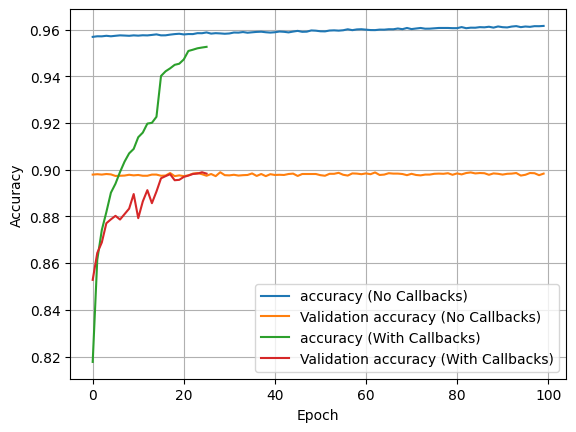

In [10]:
import matplotlib.pyplot as plt

def plot_comparison(history_without_callbacks, history_with_callbacks, metric):
    plt.plot(history_without_callbacks.history[metric], label=f"{metric} (No Callbacks)")
    plt.plot(history_without_callbacks.history[f"val_{metric}"], label=f"Validation {metric} (No Callbacks)")
    plt.plot(history_with_callbacks.history[metric], label=f"{metric} (With Callbacks)")
    plt.plot(history_with_callbacks.history[f"val_{metric}"], label=f"Validation {metric} (With Callbacks)")
    plt.xlabel('Epoch')
    plt.ylabel(metric.capitalize())
    plt.legend()
    plt.grid()
    plt.show()

# Train the model without callbacks
history_without_callbacks = model.fit(x_train, y_train,
                                      epochs=100,
                                      batch_size=32,
                                      validation_split=0.2,
                                      verbose=0)

# Plot the comparison of validation loss
plot_comparison(history_without_callbacks, history, 'loss')

# Plot the comparison of validation accuracy
plot_comparison(history_without_callbacks, history, 'accuracy')
